# Quadcopter Activity Recognition 

Welcome to this training module that teaches you how to perform activity recognition with the help of a hosted Machine Learning instance. This notebook will guide you through the process of extracting information from your flight record!

## Getting started

So let's start with what group name you are... this will help me pull your raw accelerometer data from the cloud

In [5]:
# import necessary libraries
import json
import boto3
import boto3.session
import string
import os
import csv

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from csv import reader

s3_workspace_bucket = 'mldelarosa-thesis'

s3_subdir_group_classification_flight_log = 'mar-lab-workspace/exercise-classifying/group-classification-dataset/'
s3_subdir_group_classification_dataset = 'mar-lab-workspace/exercise-classifying/group-classification-dataset/'

jupyter_subdir_group_classification_dataset = './data/group-dataset/'
jupyter_subdir_group_classification_flight_log = './data/group-logs/'
jupyter_subdir_group_workspace = './data/group-workspace/'


def make_directory(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

def get_s3_client():
    session = boto3.session.Session()
    s3 = session.resource(service_name='s3', verify=True)
    return s3.meta.client

print('[DONE] Runtime initialized')

[DONE] Runtime initialized


In [6]:
GROUP_NAME = 'default'
#GROUP_NAME = input('Group Name: ')
print ('Pulling latest flight log data from S3 for group [' + GROUP_NAME + ']');

client = get_s3_client()
s3_filepath_group_classification_dataset_latest = s3_subdir_group_classification_dataset + GROUP_NAME + '/imu-data-log-latest';
jupyter_filepath_group_classification_dataset_latest = jupyter_subdir_group_classification_dataset + GROUP_NAME + '/imu-latest-dataset.csv';

print('Downloading from: ' + s3_workspace_bucket + '/' + s3_filepath_group_classification_dataset_latest)

make_directory(jupyter_filepath_group_classification_dataset_latest)
print('Downloading to: ' + jupyter_filepath_group_classification_dataset_latest)
group_flight_record = client.download_file(Bucket=s3_workspace_bucket,
                                           Key=s3_filepath_group_classification_dataset_latest,
                                           Filename=jupyter_filepath_group_classification_dataset_latest)

print('[DONE]')

Pulling latest flight log data from S3 for group [default]
[DONE]


In [8]:
print ('Pulling flight data from S3 for group [', GROUP_NAME ,'] ...')

client = get_s3_client();
s3_filepath_group_classification_flight_log_latest = s3_subdir_group_classification_logs + GROUP_NAME + '/flight-log-latest';
jupyter_filepath_group_classification_flight_log_latest = jupyter_subdir_group_workspace + GROUP_NAME + '/flight-log-latest.txt';


print('Getting from: ' + s3_workspace_bucket + '/' + s3_filepath_group_classification_flight_log_latest);
make_directory(jupyter_filepath_group_classification_flight_log_latest);
print('Downloading to:   ' + jupyter_filepath_group_classification_flight_log_latest);

group_flight_record = client.download_file(Bucket=s3_workspace_bucket,
                                           Key=s3_filepath_group_classification_flight_log_latest,
                                           Filename=jupyter_filepath_group_classification_flight_log_latest)
print('[DONE]\n')
print('========= ' + GROUP_NAME + ' FLIGHT LOG =========')
with open(jupyter_filepath_group_classification_flight_log_latest, 'r') as flightLog:
    print(flightLog.read())

Pulling flight data from S3 for group [ default ] ...
Getting from: mldelarosa-thesis/mar-lab-workspace/exercise-classifying/group-classification-dataset/default/flight-log-latest
[DONE]

========= default FLIGHT LOG =========
[ENABLED] TRAINING MODE for LABELLED raw IMU CSV data log...
Setting Roll Acc_Trim [0]
Setting Roll Acc_Trim [0]
Initializing PID Flight Controller...
Initializing Analog and GPIO pins...
Initializing I2C Devices...
[DONE] Initialized I2C in Fast mode....
Initializing I2C Slave Device....
Constructing Gyro...
Initializing Gyro I2C Device....
[DONE] Initialized Gyro I2C Device....
Constructing ESC Controller...
Initializing ESC Controller I2C Device....
[DONE] Initialized ESC Controller I2C Device....
Initializing runtime variables...
[Done] Sample Time - uSeconds = 4000
[Done] Loop Timeout - uSeconds = 4000
ENTER SETUP
Calibrating Gyro Device...
Finished Gyro Callibration...
EXIT SETUP 
[Warning] Running slow by -2.9999e+06
[Warning] Running slow by -3887
[Warnin

# Flight log

Let's pull up your flight log! See how your quadrotor performed during your flight...

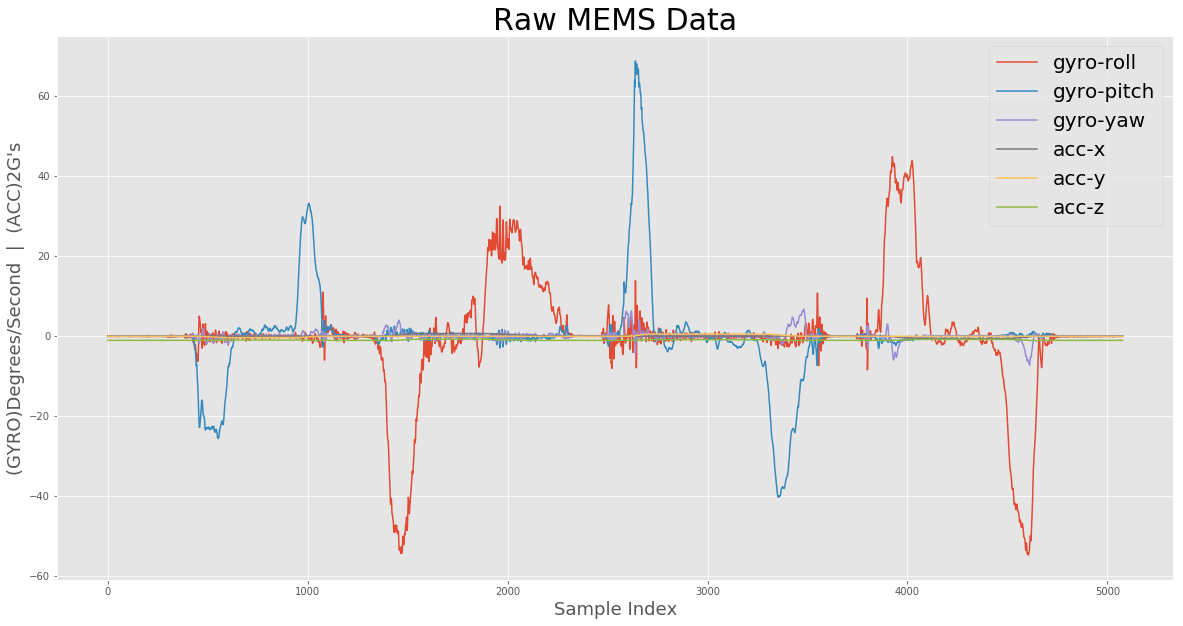

In [9]:
# split flight data into windows of data samples for each label
matplotlib.rcParams['figure.figsize'] = (20, 10)
matplotlib.rcParams['toolbar'] = 'toolbar2'

def graph_raw_flight_record_data(data_filepath):
    with open(data_filepath) as raw_flight_record:
        raw_imu_data = list(reader(raw_flight_record))
        global FLIGHT_RECORD_LENGTH
        FLIGHT_RECORD_LENGTH = len(raw_imu_data)
    plt.style.use('ggplot')
    acc_x = [float(i[0]) for i in raw_imu_data[1::]]
    acc_y = [float(i[1]) for i in raw_imu_data[1::]]
    acc_z = [float(i[2]) for i in raw_imu_data[1::]]
    gyro_roll = [float(i[3]) for i in raw_imu_data[1::]]
    gyro_pitch = [float(i[4]) for i in raw_imu_data[1::]]
    gyro_yaw = [float(i[5]) for i in raw_imu_data[1::]]
    x_t_index = range(1, len(gyro_roll))
    plt.ion()
    plt.plot(gyro_roll)
    plt.plot(gyro_pitch)
    plt.plot(gyro_yaw)
    plt.plot(acc_x)
    plt.plot(acc_y)
    plt.plot(acc_z)
#     plt.gca().set_ylim([-12000, 12000])
    plt.legend(['gyro-roll', 'gyro-pitch', 'gyro-yaw', 'acc-x', 'acc-y', 'acc-z'], fontsize=20)
    plt.title('Raw MEMS Data', fontsize=30)
    plt.xlabel('Sample Index', fontsize=18)
    plt.ylabel('(GYRO)Degrees/Second  |  (ACC)2G\'s', fontsize=18)
    plt.show()
    
graph_raw_flight_record_data(jupyter_filepath_group_classification_dataset_latest)

# Convert TRAINING & EVALUATION for model data (annotated)

## Convert data into a feature space
Extract a features of a sliding window from a given sample data.

In [10]:
# Download prepped training data
print('Getting from: /edison-quadcopter/data-flight-recordings/model/training/quadrotor-default-group/labelled-raw-mems-output-latest')
make_directory('./data/training/raw-mems-output-latest.csv')
group_flight_record = client.download_file(Bucket='mldelarosa-thesis',
                                           Key='edison-quadcopter/data-flight-recordings/model/training/quadrotor-default-group/labelled-raw-mems-output-latest',
                                           Filename='./data/training/raw-mems-output-latest.csv')
print('DONE')

Getting from: /edison-quadcopter/data-flight-recordings/model/training/quadrotor-default-group/labelled-raw-mems-output-latest
DONE


In [11]:
def extract_label_sets_from_file(data_filepath, destination_dir):
    labelled_file = open(data_filepath, 'r')
    
    csv_columns = ['accelerometer_x','accelerometer_y','accelerometer_z','gyrometer_x','gyrometer_y','gyrometer_z']
    
    running_index = 0
    running_label = ''
    running_sample_index = {}
    running_sample_filename = ''
    labelled_row_reader = csv.DictReader(labelled_file)
    for labelled_row in labelled_row_reader:
        if(running_label != labelled_row['label']):
            # Iterate sample file index for the current label
            running_label = labelled_row['label']
            if running_label in running_sample_index.keys():
                running_sample_index[running_label] = running_sample_index[running_label] + 1;
            else:
                running_sample_index[running_label] = 0;
            running_index = 0;
            running_sample_filename = destination_dir + '/' + running_label + '/' + running_label + '-sample-' + str(running_sample_index[running_label]) + '.csv'
            make_directory(running_sample_filename)
            running_sample_file = open(running_sample_filename, 'w')
            running_sample_file.write(','.join(csv_columns) + '\n')
            running_sample_file.write(labelled_row['accelerometer_x']
                                + ',' + labelled_row['accelerometer_y']
                                + ',' + labelled_row['accelerometer_z']
                                + ',' + labelled_row['gyrometer_x']
                                + ',' + labelled_row['gyrometer_y']
                                + ',' + labelled_row['gyrometer_z'] + '\n')
        else:
            running_index = running_index + 1
            running_sample_file.write(labelled_row['accelerometer_x']
                                + ',' + labelled_row['accelerometer_y']
                                + ',' + labelled_row['accelerometer_z']
                                + ',' + labelled_row['gyrometer_x']
                                + ',' + labelled_row['gyrometer_y']
                                + ',' + labelled_row['gyrometer_z'] + '\n')
            
            
extract_label_sets_from_file('./data/training/raw-mems-output-latest.csv', './data/training/session-latest/')
print('DONE')

DONE


In [12]:
#TODO: Change rotor label to the appropriate flight controls
import csv
from itertools import islice
import numpy as np

FEATURE_DATA_FILEPATH = './data/'

feature_csv_columns = ['average', 'median']
imu_data_columns = ['accelerometer_x','accelerometer_y','accelerometer_z','gyrometer_x','gyrometer_y','gyrometer_z']

def feature_average(data_sample):
    fSum = 0;
    nIndex = 0;
    for data in data_sample:
        fSum = fSum + data
        nIndex = nIndex + 1
    return float(fSum / nIndex)

def feature_variance(data_sample):
    return np.var(data_sample)

def feature_median(data_sample):
    return np.median(data_sample, axis=0)

feature_calculations = {
    'average' : feature_average,
    'median' : feature_median
}

# Read a *.csv file and extract the sliding window
import collections
def extract_features_from_imu_data_samples_for_label(data_sample_filepath, features_filepath, data_label):
#     print('Extracting for feature: ', data_label, 'from', data_sample_filepath)
    with open(data_sample_filepath, 'r') as csv_file:
        # extract data records by row
        reader = csv.DictReader(csv_file)
        sliding_windows = []
        sliding_index = 0
        window_step_forward = 1
        window_length = 4
#         if(len(list(reader)) < window_length):
#             print('File too short [' + data_sample_filepath + ']')
#             return
        
        # extract sliding windows from rows
        sliding_window_csv = []
        for row in reader:
            sliding_window_csv.append(row)
            if(len(sliding_window_csv) == window_length + 1):
                del sliding_window_csv[0]
            if(sliding_index % window_step_forward == 0 and len(sliding_window_csv) == window_length):
                sliding_windows.append(list(sliding_window_csv))
            sliding_index = sliding_index + 1
        running_window_lines = []
                
        for feature_name, feature_func in feature_calculations.items():
            for imu_data_column in imu_data_columns:
                window_sequences = []
                for sliding_window in sliding_windows:
                    window_sequence = []
                    for window in sliding_window:
                        window_sequence.append(float(window[imu_data_column]))
                    window_sequences.append(window_sequence)
#                 print(imu_data_column, ' - ', window_sequences)
                
                window_index = 0
                comma_index = 0;
                window_count = len(window_sequences)
                while len(running_window_lines) < window_count:
                    running_window_lines.append('')
                for window in window_sequences:
                    running_window_lines[window_index % window_count] += (str(feature_func(window))) + ','
#                     print(imu_data_column, ' _ ', feature_name, feature_func(window))
                    window_index = window_index + 1
#     print('PRINT FOR WINDOW ', window_count , running_window_lines)

    with open(features_filepath, 'a') as features_file:
        for feature_line in running_window_lines:
            features_file.write(data_label + ',' + feature_line[:-1] + '\n')
            

# Iterate through the raw IMU data directories and get their labels
import glob
import os
labels = set()
print('Extracting labels for samples in raw training data directory:')
for raw_data_dir in glob.glob('./data/training/session-latest/*', recursive=True):
    labels.add(os.path.basename(raw_data_dir))
print(labels)

# labels = set()
# print('Extracting labels for samples in raw evaluation data directory:')
# for raw_data_dir in glob.glob('./data/evaluation/raw/samples/*', recursive=True):
#     labels.add(os.path.basename(raw_data_dir))
# print(labels)

#os.remove('./data/features.csv')
with open('./data/training-feature-data.csv', 'w') as file:
    file.write('')

# with open('./data/evaluation-feature-data.csv', 'w') as file:
#     file.write('')

# Don't include first csv row for training files
#     running_line = 'label,'
#     for feature_columns in feature_csv_columns:
#         for imu_data_column in imu_data_columns:
#             running_line += feature_columns + '_' + imu_data_column + ','
#     running_line = running_line[:-1]
#     running_line += '\n'


# Iterate through each raw IMU data sample and extract their features:
for labelled_features in labels:
    for raw_data_dir in glob.glob('./data/training/session-latest/' + labelled_features + '/*.csv', recursive=False):
#         print("Extracting features from " + raw_data_dir)
        extract_features_from_imu_data_samples_for_label(raw_data_dir, './data/training/training-feature-data-latest.csv', labelled_features)

# for labelled_features in labels:
#     for raw_data_dir in glob.glob('./data/evaluation/raw/samples/' + labelled_features + '/*.csv', recursive=False):
# #         print("Extracting features from " + raw_data_dir)
#         extract_features_from_imu_data_samples_for_label(raw_data_dir, './data/evaluation-feature-data.csv', labelled_features)

Extracting labels for samples in raw training data directory:
{'flight', 'forward', 'backward', 'left', 'neutral', 'right'}


# Prep Group data for PREDICTION (not labelled)

In [14]:
#TODO: Change rotor label to the appropriate flight controls
import csv
from itertools import islice
import numpy as np

FEATURE_DATA_FILEPATH = './data/'
WINDOW_LENGTH = 4

feature_csv_columns = ['average', 'median']
imu_data_columns = ['accelerometer_x','accelerometer_y','accelerometer_z','gyrometer_x','gyrometer_y','gyrometer_z']

def feature_average(data_sample):
    fSum = 0;
    nIndex = 0;
    for data in data_sample:
        fSum = fSum + data
        nIndex = nIndex + 1
    return float(fSum / nIndex)

def feature_variance(data_sample):
    return np.var(data_sample)

def feature_median(data_sample):
    return np.median(data_sample, axis=0)

feature_calculations = {
    'average' : feature_average,
    'median' : feature_median
}

# Read a *.csv file and extract the sliding window
import collections
def extract_features_from_imu_data(data_sample_filepath, features_filepath):
    with open(features_filepath, 'a') as features_file:
        csv_column_row = ''
        for feature_name in feature_csv_columns:
            for imu_data_column in imu_data_columns:
                csv_column_row += imu_data_column + '_' + feature_name + ','
        features_file.write(csv_column_row[:-1] + '\n')   
    
#     print('Extracting for feature: ', 'from', data_sample_filepath)
    with open(data_sample_filepath, 'r') as csv_file:
        # extract data records by row
        reader = csv.DictReader(csv_file)
        sliding_windows = []
        sliding_index = 0
        window_step_forward = 1
        window_length = 4
#         if(len(list(reader)) < window_length):
#             print('File too short [' + data_sample_filepath + ']')
#             return
        
        # extract sliding windows from rows
        sliding_window_csv = []
        for row in reader:
            sliding_window_csv.append(row)
            if(len(sliding_window_csv) == window_length + 1):
                del sliding_window_csv[0]
            if(sliding_index % window_step_forward == 0 and len(sliding_window_csv) == window_length):
                sliding_windows.append(list(sliding_window_csv))
            sliding_index = sliding_index + 1
        running_window_lines = []
                
        for feature_name in feature_csv_columns:
            for imu_data_column in imu_data_columns:
                window_sequences = []
                for sliding_window in sliding_windows:
                    window_sequence = []
                    for window in sliding_window:
                        window_sequence.append(float(window[imu_data_column]))
                    window_sequences.append(window_sequence)
#                 print(imu_data_column, ' - ', window_sequences)
                
                window_index = 0
                comma_index = 0;
                window_count = len(window_sequences)
                while len(running_window_lines) < window_count:
                    running_window_lines.append('')
                for window in window_sequences:
                    feature_func = feature_calculations[feature_name]
                    running_window_lines[window_index % window_count] += (str(feature_func(window))) + ','
#                     print(imu_data_column, ' _ ', feature_name, feature_func(window))
                    window_index = window_index + 1
#     print('PRINT FOR WINDOW ', window_count , running_window_lines)
    
    with open(features_filepath, 'a') as features_file:
        for feature_line in running_window_lines:
            features_file.write(feature_line[:-1] + '\n')
            
    
            

# Iterate through each raw IMU data sample and extract their features:
make_directory('./data/evaluation-by-group/' + GROUP_NAME + '/mems-feature-latest.csv')
with open('./data/evaluation-by-group/' + GROUP_NAME + '/mems-feature-latest.csv', 'w') as file:
    file.write('')
    print('Clearing file...')
print('Extracting features from raw mems data...')
extract_features_from_imu_data('./data/evaluation-by-group/' + GROUP_NAME + '/raw-mems-output-latest.csv', './data/evaluation-by-group/' + GROUP_NAME + '/mems-feature-latest.csv')
print('DONE')

Clearing file...
Extracting features from raw mems data...


FileNotFoundError: [Errno 2] No such file or directory: './data/evaluation-by-group/default/raw-mems-output-latest.csv'

In [12]:
import random

flightRecordLength = FLIGHT_RECORD_LENGTH

def graph_random_sample_for_group_data(flightRecordLength):
    if(flightRecordLength < 10+2*WINDOW_LENGTH):
        print('Flight record too short to extract features [' + str(flightRecordLength) + ']')
    else:
        global randomSampleIndex
        randomSampleIndex = random.randint(1, flightRecordLength - 2 - WINDOW_LENGTH)
        print('Let\'s start at some index within your sample, let\'s say at index', randomSampleIndex)

        with open(GROUP_FLIGHT_RECORDING_FILEPATH, 'r') as csv_file:
            # extract data records by row
            reader = csv.DictReader(csv_file)
            sliding_windows = []
            sliding_index = 0
            window_step_forward = 1
            window_length = 4

            # extract sliding windows from rows
            sliding_window_csv = []
            sampleIndex = 0;
            for row in reader:
                sampleIndex = sampleIndex + 1

                if(sampleIndex < randomSampleIndex and sampleIndex < randomSampleIndex + WINDOW_LENGTH + 1):
                    sliding_window_csv.append(row)
                if(len(sliding_window_csv) == window_length + 1):
                    del sliding_window_csv[0]
                if(sliding_index % window_step_forward == 0 and len(sliding_window_csv) == window_length):
                    sliding_windows.append(list(sliding_window_csv))
                sliding_index = sliding_index + 1
            running_window_lines = []

            for feature_name in feature_csv_columns:
                for imu_data_column in imu_data_columns:
                    window_sequences = []
                    for sliding_window in sliding_windows:
                        window_sequence = []
                        for window in sliding_window:
                            window_sequence.append(float(window[imu_data_column]))
                        window_sequences.append(window_sequence)
#                     print(imu_data_column, ' - ', window_sequences)

                    window_index = 0
                    comma_index = 0;
                    window_count = len(window_sequences)
                    while len(running_window_lines) < window_count:
                        running_window_lines.append('')
                    for window in window_sequences:
                        feature_func = feature_calculations[feature_name]
                        running_window_lines[window_index % window_count] += (str(feature_func(window))) + ','
#                         print(imu_data_column, ' _ ', feature_name, feature_func(window))
                        window_index = window_index + 1

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from csv import reader

matplotlib.rcParams['figure.figsize'] = (20, 10)
matplotlib.rcParams['toolbar'] = 'toolbar2'
FLIGHT_RECORD_LENGTH = 0
def graph_raw_flight_record_data_with_sample(data_filepath, start_sample_index, end_sample_index):
    with open(data_filepath) as raw_flight_record:
        raw_imu_data = list(reader(raw_flight_record))
        global FLIGHT_RECORD_LENGTH
        FLIGHT_RECORD_LENGTH = len(raw_imu_data)
    plt.style.use('ggplot')
    gyro_roll = [float(i[0]) for i in raw_imu_data[1::]]
    gyro_pitch = [float(i[1]) for i in raw_imu_data[1::]]
    gyro_yaw = [float(i[2]) for i in raw_imu_data[1::]]
    acc_x = [float(i[3]) for i in raw_imu_data[1::]]
    acc_y = [float(i[4]) for i in raw_imu_data[1::]]
    acc_z = [float(i[5]) for i in raw_imu_data[1::]]
    x_t_index = range(1, len(gyro_roll))
    plt.plot(gyro_roll)
    plt.plot(gyro_pitch)
    plt.plot(gyro_yaw)
    plt.plot(acc_x)
    plt.plot(acc_y)
    plt.plot(acc_z)
    plt.axvline(start_sample_index, 0, 1, color='k', linestyle='dashed')
    plt.axvline(end_sample_index, 0, 1, color='k', linestyle='dashed')
#     plt.gca().set_ylim([-12000, 12000])
    plt.legend(['acc_x','acc_y','acc_z','gyro_roll','gyro_pitch','gyro_yaw'], fontsize=20)
    plt.title('Raw Gyrometer Data', fontsize=30)
    plt.xlabel('Sample index', fontsize=18)
    plt.ylabel('LSB-Units representing Degrees/Second', fontsize=18)
    plt.title('Raw Accelerometer Data', fontsize=30)
    plt.xlabel('Sample index', fontsize=18)
    plt.ylabel('LSB-Units representing 2G\'s', fontsize=18)
    plt.show()
    
def graph_table_raw_flight_record_data_with_sample(data_filepath, start_sample_index, end_sample_index):
    with open(data_filepath) as raw_flight_record:
        raw_imu_data = list(reader(raw_flight_record))
        global FLIGHT_RECORD_LENGTH
        FLIGHT_RECORD_LENGTH = len(raw_imu_data)
    plt.style.use('ggplot')
    gyro_roll = [float(i[0]) for i in raw_imu_data[start_sample_index:end_sample_index]]
    gyro_pitch = [float(i[1]) for i in raw_imu_data[start_sample_index:end_sample_index]]
    gyro_yaw = [float(i[2]) for i in raw_imu_data[start_sample_index:end_sample_index]]
    acc_x = [float(i[3]) for i in raw_imu_data[start_sample_index:end_sample_index]]
    acc_y = [float(i[4]) for i in raw_imu_data[start_sample_index:end_sample_index]]
    acc_z = [float(i[5]) for i in raw_imu_data[start_sample_index:end_sample_index]]
    data = []
    index = 0
    for i in raw_imu_data[start_sample_index:end_sample_index]:
        data.append([float(i[0]), float(i[1]), float(i[2]), float(i[3]), float(i[4]), float(i[5])])
        index = index + 1
    columns = ['acc_x','acc_y','acc_z','gyro_roll','gyro_pitch','gyro_yaw']
    rows = list(range(start_sample_index, start_sample_index + len(gyro_roll)))
    
    matplotlib.rcParams['figure.figsize'] = (12, 1)
    fig, ax = plt.subplots()
    ax.xaxis.set_visible(False) 
    ax.yaxis.set_visible(False)
    ax.axis('off')
    ax.axis('tight')
    table = plt.table(cellText=data, rowLabels=rows, colLabels=columns, loc='center')
    table.set_fontsize(16)
    table.scale(1.7, 1.7)
    return [gyro_roll, gyro_pitch, gyro_yaw, acc_x, acc_y, acc_z]

    
graph_random_sample_for_group_data(flightRecordLength)
graph_raw_flight_record_data_with_sample(GROUP_FLIGHT_RECORDING_FILEPATH, randomSampleIndex, randomSampleIndex + WINDOW_LENGTH + 1)
print('Here are the samples from that window of data:')
randomDataSample = graph_table_raw_flight_record_data_with_sample(GROUP_FLIGHT_RECORDING_FILEPATH, randomSampleIndex, randomSampleIndex + WINDOW_LENGTH + 1)

Flight record too short to extract features [0]


NameError: name 'GROUP_FLIGHT_RECORDING_FILEPATH' is not defined

In [21]:
# Now we extract features from this window of data:
sampleColumns = imu_data_columns

def graph_features_from_imu_data_sample(data_sample, sampleLabel):
    for feature_name, feature_func in feature_calculations.items():
        print('The', sampleLabel + '_' + feature_name, 'of', data_sample, ' =', str(feature_func(data_sample)))

for index, samples in enumerate(randomDataSample):
    print('Calculating features for', sampleColumns[index], ':')
    graph_features_from_imu_data_sample(samples, sampleColumns[index])
    print('')
    
# data = []
# index = 0
# for i in raw_imu_data[start_sample_index:end_sample_index]:
#     data.append([float(i[0]), float(i[1]), float(i[2]), float(i[3]), float(i[4]), float(i[5])])
#     index = index + 1
# columns = ['gyro-roll', 'gyro-pitch', 'gyro-yaw', 'acc-x', 'acc-y', 'acc-z']
# rows = list(range(0, len(gyro_roll)))

# matplotlib.rcParams['figure.figsize'] = (12, 1)
# fig, ax = plt.subplots()
# ax.xaxis.set_visible(False) 
# ax.yaxis.set_visible(False)
# ax.axis('off')
# ax.axis('tight')
# table = plt.table(cellText=data, rowLabels=rows, colLabels=columns, loc='center')
# table.set_fontsize(16)
# table.scale(1.7, 1.7)
# return [gyro_roll, gyro_pitch, gyro_yaw, acc_x, acc_y, acc_z]

Calculating features for accelerometer_x :
The accelerometer_x_average of [-0.0759277, -0.0734863, -0.0734863, -0.0742188, -0.076416]  = -0.07470701999999999
The accelerometer_x_median of [-0.0759277, -0.0734863, -0.0734863, -0.0742188, -0.076416]  = -0.0742188

Calculating features for accelerometer_y :
The accelerometer_y_average of [0.951904, 0.949951, 0.949951, 0.950439, 0.948975]  = 0.950244
The accelerometer_y_median of [0.951904, 0.949951, 0.949951, 0.950439, 0.948975]  = 0.949951

Calculating features for accelerometer_z :
The accelerometer_z_average of [-0.158936, -0.156738, -0.156982, -0.155273, -0.155029]  = -0.1565916
The accelerometer_z_median of [-0.158936, -0.156738, -0.156982, -0.155273, -0.155029]  = -0.156738

Calculating features for gyrometer_x :
The gyrometer_x_average of [-0.254229, -0.406901, -0.284763, -0.284763, -0.223695]  = -0.29087019999999997
The gyrometer_x_median of [-0.254229, -0.406901, -0.284763, -0.284763, -0.223695]  = -0.284763

Calculating features


## Use the linear classifier

In [14]:
import tensorflow as tf
import os
import shutil
import sys

GROUP_NAME='default'

model_dir='./tmp/model/' + GROUP_NAME + '/'
feature_data='../qar-training-exercise/data/exercise-training-session/' + GROUP_NAME + '/training-feature-data-latest-unlabelled.csv'

# declare feature columns within csv
median_gyro_roll = tf.feature_column.numeric_column(key='median_gyro_roll', dtype=tf.float64);
median_gyro_pitch = tf.feature_column.numeric_column(key='median_gyro_pitch', dtype=tf.float64);
median_gyro_yaw = tf.feature_column.numeric_column(key='median_gyro_yaw', dtype=tf.float64);

median_acc_x = tf.feature_column.numeric_column(key='median_acc_x', dtype=tf.float64);
median_acc_y = tf.feature_column.numeric_column(key='median_acc_y', dtype=tf.float64);
median_acc_z = tf.feature_column.numeric_column(key='median_acc_z', dtype=tf.float64);

mean_gyro_roll = tf.feature_column.numeric_column(key='mean_gyro_roll', dtype=tf.float64);
mean_gyro_pitch = tf.feature_column.numeric_column(key='mean_gyro_pitch', dtype=tf.float64);
mean_gyro_yaw = tf.feature_column.numeric_column(key='mean_gyro_yaw', dtype=tf.float64);

# stack feature columns into a single array
imu_window_feature_columns = [median_gyro_roll, median_gyro_pitch, median_gyro_yaw,
        median_acc_x, median_acc_y, median_acc_z,
        mean_gyro_roll, mean_gyro_pitch, mean_gyro_yaw]

run_config=tf.estimator.RunConfig().replace(
    session_config=tf.ConfigProto(device_count={'GPU': 0})
)

def input_fn(data_file):
    assert tf.gfile.Exists(data_file),('%s not found')
    records_default = [[0.0], [0.0], [0.0],
                       [0.0], [0.0], [0.0],
                       [0.0], [0.0], [0.0],
                       [0.0], [0.0], [0.0]]
    csv_columns = [ 'mean_acc_x','mean_acc_y','mean_acc_z',
                    'mean_gyro_roll','mean_gyro_pitch','mean_gyro_yaw',
                    'median_acc_x','median_acc_y','median_acc_z',
                    'median_gyro_roll','median_gyro_pitch','median_gyro_yaw'
    ]
    
    def parse_csv(value):
        print('PARSING:', data_file)
        columns = tf.decode_csv(value, records_default)
        features = dict(zip(csv_columns, columns))
        return features
    
    dataset = tf.data.TextLineDataset(data_file)
    dataset = dataset.map(parse_csv, 4)
    dataset = dataset.batch(200)
    return dataset

model = tf.estimator.LinearClassifier(
    model_dir=model_dir,
    feature_columns=imu_window_feature_columns,
    config=run_config,
    n_classes=5,
    label_vocabulary=['backward', 'forward', 'left', 'neutral', 'right']
)

res = model.predict(
    input_fn=lambda: input_fn(feature_data)
)

for i, p in enumerate(res):
      print(i, p)

print('[DONE]')

/home/ec2-user/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


INFO:tensorflow:Using config: {'_model_dir': './tmp/model/default/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': device_count {
  key: "GPU"
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5062a5df28>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


ValueError: Could not find trained model in model_dir: ./tmp/model/default/.